In [ ]:
%%sh
pip install seaborn
sudo apt install -y fonts-cmu texlive-latex-extra cm-super dvipng
# mkdir out

In [4]:
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Callable, Dict, Optional, Tuple

sns.set_context("paper", font_scale=1.5)
matplotlib.rc('font', **{'family': 'serif', 'serif': ["CMU Serif"]})
matplotlib.rc('text', usetex=True)
matplotlib.font_manager.findfont("CMU Serif", rebuild_if_missing=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{bm}')

In [5]:
def load_results(
    log_directory: str,
    x_axis: str,
    filter_fn: Callable = lambda i, j, k: True,
) -> Dict:

    results = {}
    for directory in glob.glob(f"{log_directory}/*"):
        compression = int(directory.split("_")[-1][1:])
        seq_len = int(directory.split("_")[-2][1:])
        idx0 = compression if x_axis == "Sequence Length $S$" else seq_len
        idx2 = compression if x_axis == "$k$/$r$ Scale" else seq_len
        for filename in glob.glob(f"{directory}/*"):
            idx1 = filename.split("/")[-1][:-4]
            if filter_fn(compression, seq_len, idx1):
                results[idx0] = results.get(idx0, {})
                results[idx0][idx1] = results[idx0].get(idx1, {})
                results[idx0][idx1][idx2] = []
                txt_data = [*open(filename, "r").readlines()]
                for line in txt_data:
                    results[idx0][idx1][idx2] += [float(line.split(" ")[-1])]

    # Sort the results to save having to do it later on
    sorted_results = {}
    for k0 in sorted(results):
        sorted_results[k0] = {}
        for k1 in sorted(results[k0]):
            sorted_results[k0][k1] = {}
            for k2 in sorted(results[k0][k1]):
                sorted_results[k0][k1][k2] = results[k0][k1][k2]

    return sorted_results

### Plot for the paper, showing performance at 8 $\times$ compression
##### (corresponds approximately to $r = d_h/12$, $k = S/12$)

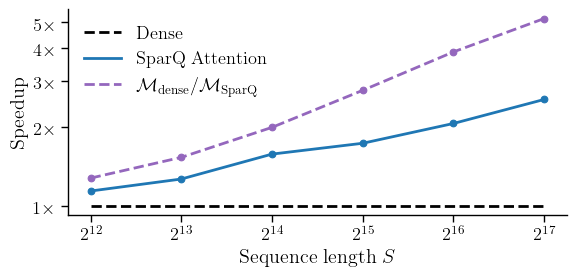

In [6]:
PARAM_SCALE = 12

fig = plt.figure(figsize=(6, 3))


# Logged benchmark results
def plot_result_filter_fn(param_scale, seq_len, method):
    return method in ["sparq", "dense"] and param_scale == PARAM_SCALE


plot_results = load_results("./logs", "Sequence Length $S$", plot_result_filter_fn)

for idx1 in plot_results[PARAM_SCALE]:
    x = [*plot_results[PARAM_SCALE][idx1].keys()]
    y_dense = [*map(np.mean, plot_results[PARAM_SCALE]["dense"].values())]
    y_sparq = [*map(np.mean, plot_results[PARAM_SCALE][idx1].values())]
    y = [i / j for i, j in zip(y_dense, y_sparq)]
    label = "Dense" if idx1 == "dense" else "SparQ Attention"
    color = "k" if idx1 == "dense" else "C0"
    linestyle = "dashed" if idx1 == "dense" else "solid"
    if idx1 != "dense":
        plt.scatter(x, y, color=color)
    plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=2)


# Theoretical maximum results
LLAMA_2_CONFIG = dict(
    batch_size=1,
    hidden_dim=4096,
    head_dim=32,
    kv_group_size=1,
    n_layers=32,
    bytes_per_param=1,
    bytes_per_kv=2,
    vocab_size=32000,
)


def get_attn_transfers(
    batch_size: int,
    seq_len: int,
    hidden_dim: int,
    kv_group_size: int,
    n_layers: int,
    bytes_per_kv: float,
    **kwargs,
) -> int:
    n_kv_elements = batch_size * n_layers * 2 * seq_len * hidden_dim // kv_group_size
    memory_transfer = n_kv_elements * bytes_per_kv
    return memory_transfer


def get_non_attn_transfers(
    batch_size: int,
    seq_len: int,
    hidden_dim: int,
    kv_group_size: int,
    n_layers: int,
    bytes_per_param: float,
    bytes_per_kv: float,
    vocab_size: Optional[int],
    **kwargs,
) -> int:
    embed_params = hidden_dim * vocab_size
    model_params = n_layers * 12 * hidden_dim**2
    memory_transfer = (model_params + 2 * embed_params) * bytes_per_param
    return memory_transfer


x, y = [], []
for S in plot_results[PARAM_SCALE]["dense"]:
    d = LLAMA_2_CONFIG["head_dim"]
    r = d // PARAM_SCALE
    k = S // PARAM_SCALE
    m_sparq = (S * r) + (2 * k * d) + (4 * d)
    m_dense = (2 * S * d) + (2 * d)
    compression_ratio = m_sparq / m_dense

    non_attn_transfers = get_non_attn_transfers(**LLAMA_2_CONFIG, seq_len=S)
    dense_attn_transfers = get_attn_transfers(**LLAMA_2_CONFIG, seq_len=S)
    sparq_attn_transfers = compression_ratio * dense_attn_transfers

    dense_total_transfers = non_attn_transfers + dense_attn_transfers
    sparq_total_transfers = non_attn_transfers + sparq_attn_transfers

    x, y = x + [S], y + [dense_total_transfers / sparq_total_transfers]

label = "$\mathcal{M}_\mathrm{dense} / \mathcal{M}_\mathrm{SparQ}$"

plt.scatter(x, y, color="C4")
plt.plot(x, y, label=label, color="C4", linestyle="dashed", linewidth=2)


x_ticks = range(12, 18)
y_ticks = [1, 2, 3, 4, 5]
x_tick_fn = lambda x: "$2^{" + str(x) + "}$"
y_tick_fn = lambda x: "" if x in [3.5, 4.5] else f"{x}$\\times$"

sns.despine()

plt.semilogx()
plt.semilogy()


plt.legend(frameon=False)
plt.xlabel("Sequence length $S$")
plt.ylabel("Speedup")

plt.xticks([2**i for i in x_ticks], map(x_tick_fn, x_ticks))
plt.yticks(y_ticks, map(y_tick_fn, y_ticks))
plt.minorticks_off()
plt.tight_layout()
plt.savefig("./out/sparq-speedup.pdf")

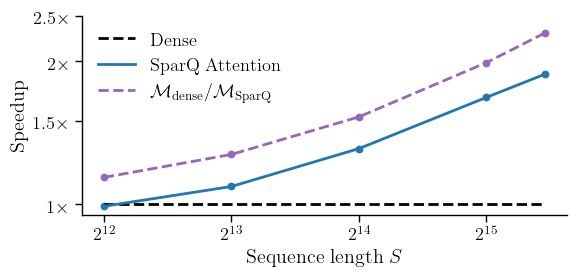

In [8]:
fig = plt.figure(figsize=(6, 3))

x = [4096, 8192, 16384, 32768, 45000]
plt.plot(x, [1.0] * len(x), label="Dense", color="k", linestyle="dashed", linewidth=2)

# BF16 results
sparq_y = [0.99, 1.09, 1.31, 1.68, 1.88]
plt.scatter(x, sparq_y, color="C0")
plt.plot(x, sparq_y, label="SparQ Attention", color="C0", linewidth=2)


# Theoretical maximum results
LLAMA_2_CONFIG = dict(
    batch_size=1,
    hidden_dim=4096,
    head_dim=32,
    kv_group_size=1,
    n_layers=32,
    bytes_per_param=2,
    bytes_per_kv=2,
    vocab_size=32000,
)


def get_attn_transfers(
    batch_size: int,
    seq_len: int,
    hidden_dim: int,
    kv_group_size: int,
    n_layers: int,
    bytes_per_kv: float,
    **kwargs,
) -> int:
    n_kv_elements = batch_size * n_layers * 2 * seq_len * hidden_dim // kv_group_size
    memory_transfer = n_kv_elements * bytes_per_kv
    return memory_transfer


def get_non_attn_transfers(
    batch_size: int,
    seq_len: int,
    hidden_dim: int,
    kv_group_size: int,
    n_layers: int,
    bytes_per_param: float,
    bytes_per_kv: float,
    vocab_size: Optional[int],
    **kwargs,
) -> int:
    embed_params = hidden_dim * vocab_size
    model_params = n_layers * 12 * hidden_dim**2
    memory_transfer = (model_params + 2 * embed_params) * bytes_per_param
    return memory_transfer


x = [4096, 8192, 16384, 32768, 45000]

y = []
for S in x:
    d = LLAMA_2_CONFIG["head_dim"]
    r = d // PARAM_SCALE
    k = S // PARAM_SCALE
    m_sparq = (S * r) + (2 * k * d) + (4 * d)
    m_dense = (2 * S * d) + (2 * d)
    compression_ratio = m_sparq / m_dense

    non_attn_transfers = get_non_attn_transfers(**LLAMA_2_CONFIG, seq_len=S)
    dense_attn_transfers = get_attn_transfers(**LLAMA_2_CONFIG, seq_len=S)
    sparq_attn_transfers = compression_ratio * dense_attn_transfers

    dense_total_transfers = non_attn_transfers + dense_attn_transfers
    sparq_total_transfers = non_attn_transfers + sparq_attn_transfers

    y += [dense_total_transfers / sparq_total_transfers]

label = "$\mathcal{M}_\mathrm{dense} / \mathcal{M}_\mathrm{SparQ}$"

plt.scatter(x, y, color="C4")
plt.plot(x, y, label=label, color="C4", linestyle="dashed", linewidth=2)


x_ticks = range(12, 16)
y_ticks = [1, 1.5, 2, 2.5]
x_tick_fn = lambda x: "$2^{" + str(x) + "}$"
y_tick_fn = lambda x: "" if x in [3.8, 4.5] else f"{x}$\\times$"

sns.despine()

plt.semilogx()
plt.semilogy()


plt.legend(frameon=False)
plt.xlabel("Sequence length $S$")
plt.ylabel("Speedup")

plt.xticks([2**i for i in x_ticks], map(x_tick_fn, x_ticks))
plt.yticks(y_ticks, map(y_tick_fn, y_ticks))
plt.minorticks_off()
plt.tight_layout()
plt.savefig("./out/sparq-speedup-h100.pdf")